In [3]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler

plt.style.use('seaborn-v0_8-whitegrid')
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [4]:
# open the tsv file
# data=pd.read_csv('yellowstone.tsv', sep='\t')

# save as csv
# data.to_csv('yellowstone6192500.csv', index=False)

#This was only needed once to convert the tsv to csv

#there is now a new script that runs and fetches the data from the API

# EDA
This project is an effort to see if the spring increase in discharge can be predicted from publicly available streamflow data.

The Yellowstone river was selected as it is an undammed river with readily accessible data. 

The data is from the Yellowstone river at Livingston MT. The data is from the USGS and is available at https://waterdata.usgs.gov/mt/nwis/uv?site_no=06192500


In [5]:
data=pd.read_csv('yellowstone6192500.csv')

data['datetime'] = pd.to_datetime(data['datetime'])

print(data.head())


  agency_cd         id            datetime timezone discharge
0      USGS  6192500.0 1995-10-01 00:15:00      MDT      2210
1      USGS  6192500.0 1995-10-01 00:30:00      MDT      2210
2      USGS  6192500.0 1995-10-01 00:45:00      MDT      2200
3      USGS  6192500.0 1995-10-01 01:00:00      MDT      2210
4      USGS  6192500.0 1995-10-01 01:15:00      MDT      2200


/tmp/ipykernel_743865/1885298459.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('yellowstone6192500.csv')


In [6]:
print(data.tail())

       agency_cd         id            datetime timezone discharge
984697      USGS  6192500.0 2025-03-17 03:15:00      MDT      1160
984698      USGS  6192500.0 2025-03-17 03:30:00      MDT      1170
984699      USGS  6192500.0 2025-03-17 03:45:00      MDT      1160
984700      USGS  6192500.0 2025-03-17 04:00:00      MDT      1180
984701       NaN        NaN                 NaT      NaN       NaN


<Axes: xlabel='datetime'>

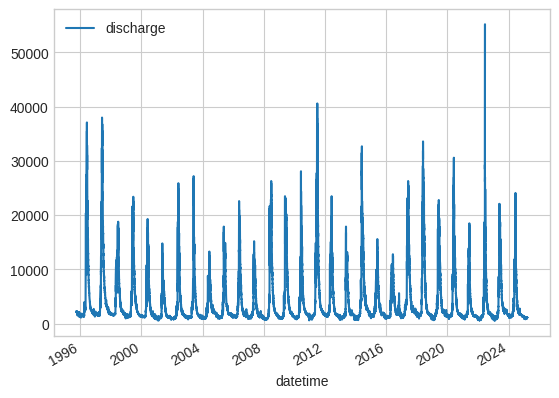

In [7]:
# Convert the discharge column to numeric, coercing errors to NaN
data['discharge'] = pd.to_numeric(data['discharge'], errors='coerce')

# Plot the data
data.plot(x='datetime', y='discharge')

From this chart we can see that there is indeed an increase of discharge every spring.  However, the magnitude of this increase varies quite a bit from year to year.

In [8]:
data['year']=data['datetime'].dt.year

data.head()

,agency_cd,id,datetime,timezone,discharge,year
0,USGS,6192500.0,1995-10-01 00:15:00,MDT,2210.0,1995.0
1,USGS,6192500.0,1995-10-01 00:30:00,MDT,2210.0,1995.0
2,USGS,6192500.0,1995-10-01 00:45:00,MDT,2200.0,1995.0
3,USGS,6192500.0,1995-10-01 01:00:00,MDT,2210.0,1995.0
4,USGS,6192500.0,1995-10-01 01:15:00,MDT,2200.0,1995.0


In [9]:
data.groupby(['year']).mean(numeric_only=True)

,id,discharge
year,,
1995.0,6192500.0,1907.001544
1996.0,6192500.0,6845.368189
1997.0,6192500.0,6718.100066
1998.0,6192500.0,4216.614344
1999.0,6192500.0,4376.431826
2000.0,6192500.0,3417.392292
2001.0,6192500.0,2495.945720
2002.0,6192500.0,3744.992023
2003.0,6192500.0,3547.600742


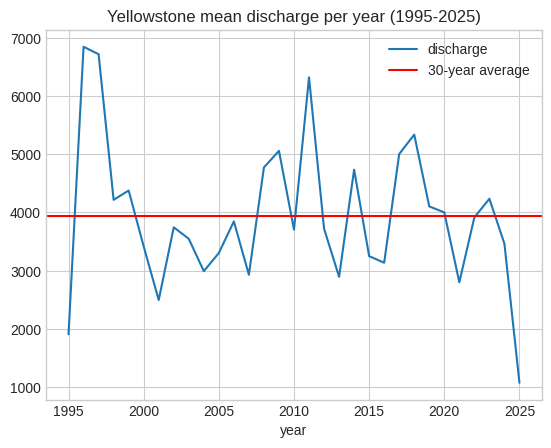

In [10]:
means = data.groupby(['year']).mean(numeric_only=True)
mean_discharge = means['discharge']
overall_mean = mean_discharge.mean()
mean_discharge.plot()
plt.axhline(y=overall_mean, color='red', label='30-year average')
plt.title("Yellowstone mean discharge per year (1995-2025)")
plt.plot(2024, mean_discharge[2024])
plt.legend()
 
 

Not only does the magnitude of the spring discharge increase every year, the mean discharge for each year also varies by quite a bit.  This is likely due to the amount of snowpack in the mountains that feed the river.  A potential future question is whether the amount of snowpack can be used to predict the spring discharge increase.  

In [11]:
data['year']

0         1995.0
1         1995.0
2         1995.0
3         1995.0
4         1995.0
           ...  
984697    2025.0
984698    2025.0
984699    2025.0
984700    2025.0
984701       NaN
Name: year, Length: 984702, dtype: float64

In [12]:
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['day_of_year'] = data['datetime'].dt.dayofyear

In [13]:
year_2021 = data[data['year'] == 2021]
year_2022 = data[data['year'] == 2022]
year_2023 = data[data['year'] == 2023]
year_2024 = data[data['year'] == 2024]
year_2025 = data[data['year'] == 2025]

In [14]:
year_2021

,agency_cd,id,datetime,timezone,discharge,year,month,day,day_of_year
838262,USGS,6192500.0,2021-01-01 00:00:00,MST,1330.0,2021.0,1.0,1.0,1.0
838263,USGS,6192500.0,2021-01-01 00:15:00,MST,1330.0,2021.0,1.0,1.0,1.0
838264,USGS,6192500.0,2021-01-01 00:30:00,MST,1330.0,2021.0,1.0,1.0,1.0
838265,USGS,6192500.0,2021-01-01 00:45:00,MST,1330.0,2021.0,1.0,1.0,1.0
838266,USGS,6192500.0,2021-01-01 01:00:00,MST,1330.0,2021.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
873132,USGS,6192500.0,2021-12-31 22:45:00,MST,NaN,2021.0,12.0,31.0,365.0
873133,USGS,6192500.0,2021-12-31 23:00:00,MST,NaN,2021.0,12.0,31.0,365.0
873134,USGS,6192500.0,2021-12-31 23:15:00,MST,619.0,2021.0,12.0,31.0,365.0
873135,USGS,6192500.0,2021-12-31 23:30:00,MST,NaN,2021.0,12.0,31.0,365.0


In [15]:
discharge_2021 = year_2021[['day_of_year', 'discharge']]
discharge_2022 = year_2022[['day_of_year', 'discharge']]
discharge_2023 = year_2023[['day_of_year', 'discharge']]
discharge_2024 = year_2024[['day_of_year', 'discharge']]
discharge_2025 = year_2025[['day_of_year', 'discharge']]
discharge_3_year = discharge_2021.merge(discharge_2022, on='day_of_year').merge(discharge_2023, on='day_of_year')
discharge_3_year.columns = ['day_of_year', 'discharge_2021', 'discharge_2022', 'discharge_2023']

Text(0.5, 0, 'Day of the year')

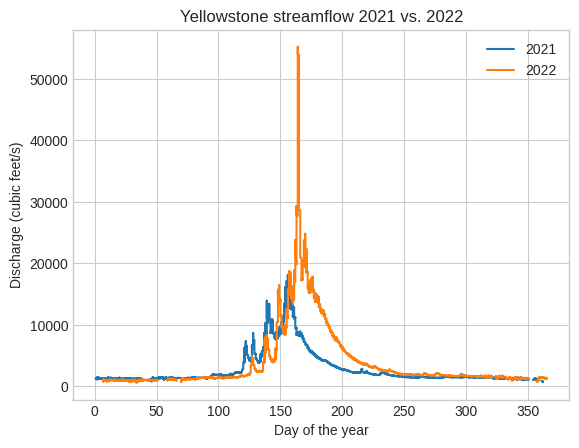

In [16]:
fig, ax = plt.subplots()
ax.plot(discharge_2021['day_of_year'], discharge_2021['discharge'], label='2021')
ax.plot(discharge_2022['day_of_year'], discharge_2022['discharge'], label='2022')
plt.legend()
plt.title('Yellowstone streamflow 2021 vs. 2022')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Day of the year')

This chart examines the 2021 vs the 2022 data.  There is quite a difference between the two.  2021's spring increase started earlier.  2022 had a much higher peak discharge than 2021.  I suspect that the amount of snowpack in the mountains was much less during 2021.  This is a potential future question to investigate.

Text(0.5, 0, 'Day of the year')

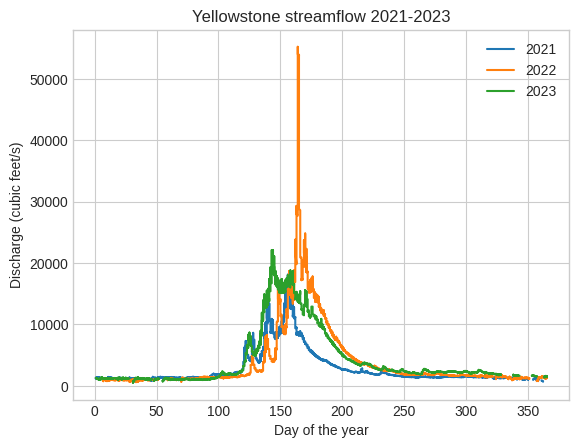

In [17]:
fig, ax = plt.subplots()
ax.plot(discharge_2021['day_of_year'], discharge_2021['discharge'], label='2021')
ax.plot(discharge_2022['day_of_year'], discharge_2022['discharge'], label='2022')
ax.plot(discharge_2023['day_of_year'], discharge_2023['discharge'], label='2023')
plt.legend()
plt.title('Yellowstone streamflow 2021-2023')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Day of the year')

Similar to the previous graph.  2023 data had a similar onset time as 2021.  The peak discharge is slightly more than 2021; bot not anywhere close to 2022.  

Text(0.5, 0, 'Day of the year')

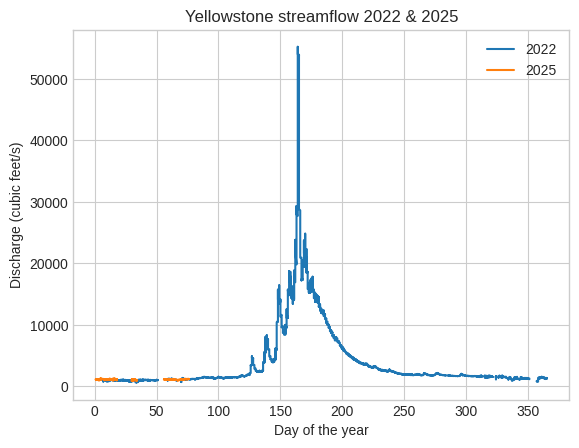

In [18]:
fig, ax = plt.subplots()
ax.plot(discharge_2022['day_of_year'], discharge_2022['discharge'], label='2022')
ax.plot(discharge_2025['day_of_year'], discharge_2025['discharge'], label='2025')
plt.legend()
plt.title('Yellowstone streamflow 2022 & 2025')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Day of the year')

It's hard to say how 2025 is progressing thus far

In [19]:
discharge=data['discharge'].to_frame()
discharge.index=data['datetime']

Text(0.5, 0, 'Date and Time(15 min intervals)')

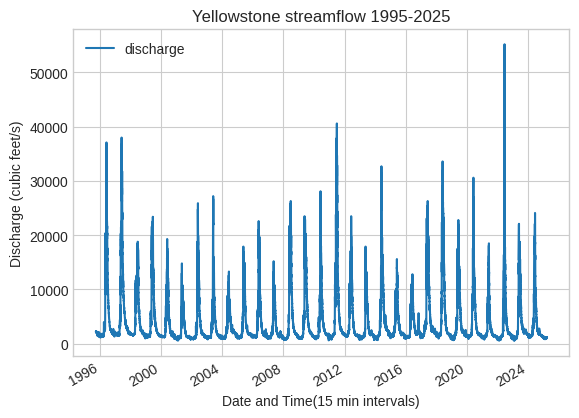

In [20]:

discharge.plot()
plt.title('Yellowstone streamflow 1995-2025')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date and Time(15 min intervals)')

In [21]:
discharge_2008 = discharge[(discharge.index >= '2008-01-01') & (discharge.index < '2009-01-01')]
discharge_2014 = discharge[(discharge.index >= '2014-01-01') & (discharge.index < '2015-01-01')]
discharge_2020 = discharge[(discharge.index >= '2020-01-01') & (discharge.index < '2021-01-01')]

Text(0.5, 0, 'Date')

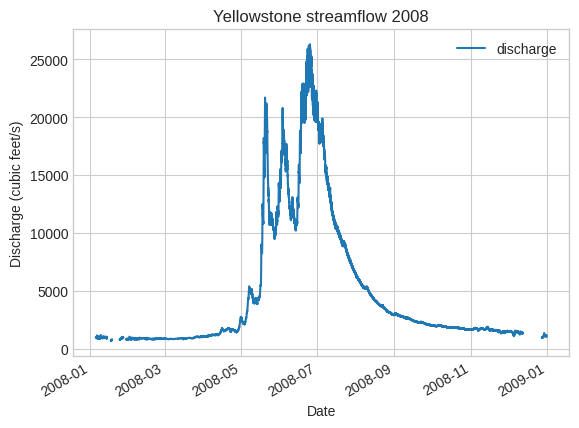

In [22]:
discharge_2008.plot()
plt.title('Yellowstone streamflow 2008')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

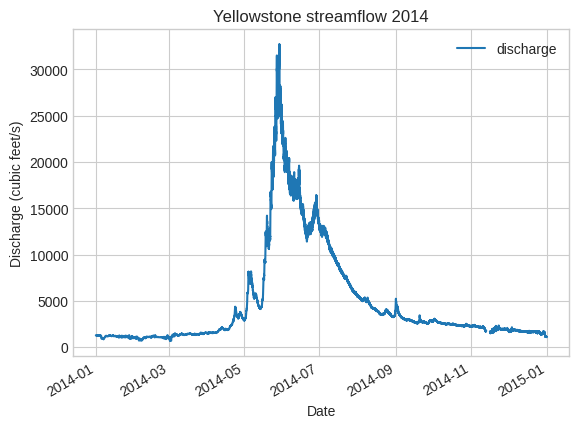

In [23]:
discharge_2014.plot()
plt.title('Yellowstone streamflow 2014')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

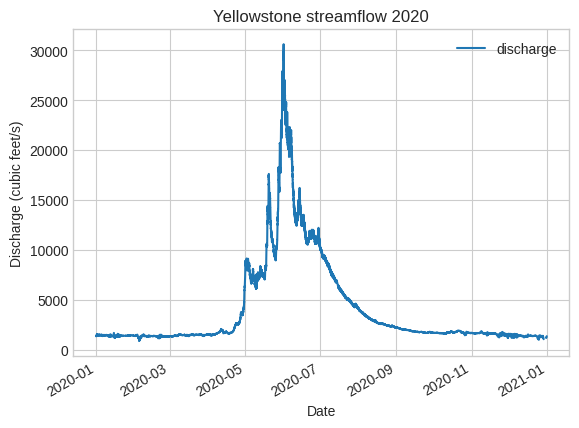

In [24]:
discharge_2020.plot()
plt.title('Yellowstone streamflow 2020')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date')

In [25]:
discharge['day_of_year'] = discharge.index.day_of_year
discharge['week'] = discharge.index.isocalendar().week.fillna(0).astype('int32')
discharge['month'] = discharge.index.month
discharge['quarter'] = discharge.index.quarter
discharge['year'] = discharge.index.year

In [26]:
discharge_consolidated = discharge.copy()
discharge_consolidated = discharge_consolidated.groupby(['year', 'day_of_year']).first()

([<matplotlib.axis.XTick at 0x74bdbf8c1940>,
 [Text(0, 0, '1'),
  Text(5, 0, '6'),
  Text(10, 0, '11'),
  Text(15, 0, '16'),
  Text(20, 0, '21'),
  Text(25, 0, '26'),
  Text(30, 0, '31'),
  Text(35, 0, '36'),
  Text(40, 0, '41'),
  Text(45, 0, '46'),
  Text(50, 0, '51')])

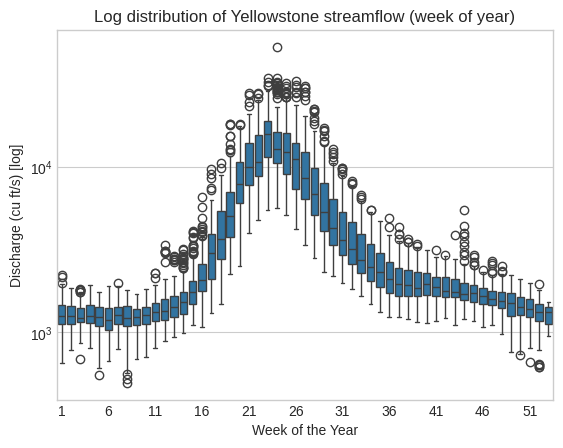

In [27]:
sns.boxplot(data=discharge_consolidated, x='week', y='discharge')
plt.ylabel('Discharge (cu ft/s) [log]')
plt.xlabel('Week of the Year')
plt.yscale('log')
plt.title('Log distribution of Yellowstone streamflow (week of year)')

plt.xticks(range(0, 53, 5))

Box and whisker plots for each week of the year.  There are many outliers during the spring and summer months.  This fits with what we already saw earlier that there is a lot of variability in the peak discharge for a given year.

Text(0.5, 1.0, 'Log distribution of Yellowstone streamflow (month of year)')

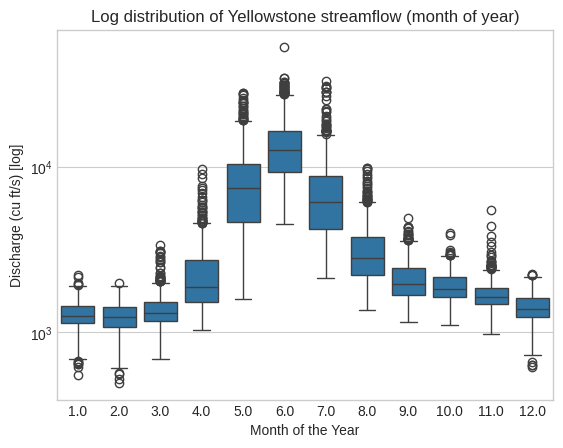

In [28]:
sns.boxplot(data=discharge_consolidated,x='month', y='discharge')
plt.ylabel('Discharge (cu ft/s) [log]')
plt.xlabel('Month of the Year')
plt.yscale('log')
plt.title('Log distribution of Yellowstone streamflow (month of year)')

Similar to the previous plot.  This plot is aggregating the data by month.  We can reach a similar conclusion though.  There is a lot of variability in the peak discharge for a given year.  Also, we can see some outliers during the winter months of December through February that are lower.  I wonder if this is due to very cold temperatures .

# Prediction
This is an effort to predict the spring increase in discharge.  The data is from the Yellowstone river at Livingston MT. The data is from the USGS and is available at https://waterdata.usgs.gov/mt/nwis/uv?site_no=06192500   

Ideally we would like to predict both the onset of the spring increase and the peak discharge.   

In [29]:
train = discharge[discharge['year']<2023]
test = discharge[discharge['year']>=2023]

Text(0, 0.5, 'Discharge (cu ft/s)')

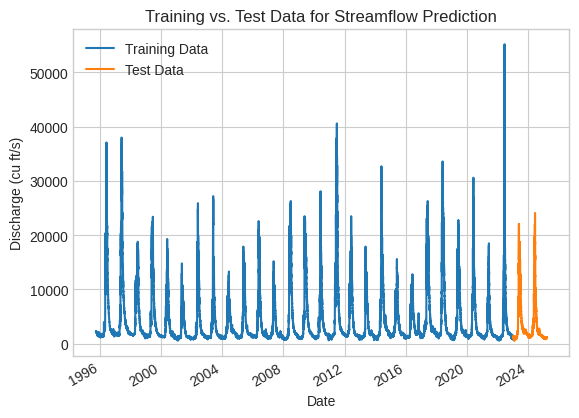

In [30]:
fig, ax = plt.subplots()
train['discharge'].plot(ax=ax)
test['discharge'].plot(ax=ax)
plt.legend(['Training Data', 'Test Data'])
plt.title('Training vs. Test Data for Streamflow Prediction')
plt.xlabel('Date')
plt.ylabel('Discharge (cu ft/s)')

The model will be trained on data from the years preceeding 2023.  The model will be tested on the 2023-2024 data.  

In [31]:
features = ['month','week', 'day_of_year']
target = 'discharge'

x_train = train[features]
y_train = train[target]

x_test = test[features]
y_test = test[target]

In [32]:
# Remove NaN values from y_train and y_test
y_train = y_train.dropna()
y_test = y_test.dropna()

# Ensure x_train and x_test match the indices of y_train and y_test
x_train = x_train.loc[y_train.index]
x_test = x_test.loc[y_test.index]

regressor = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=100)
eval_set = [(x_train, y_train), (x_test, y_test)]
regressor.fit(x_train, y_train, eval_set=eval_set, verbose=20)

[0]	validation_0-rmse:3884.21666	validation_1-rmse:3138.18653
[20]	validation_0-rmse:2561.19897	validation_1-rmse:1487.05283
[40]	validation_0-rmse:2558.90097	validation_1-rmse:1488.02035
[60]	validation_0-rmse:2558.73015	validation_1-rmse:1488.94121
[80]	validation_0-rmse:2558.49548	validation_1-rmse:1489.38372
[100]	validation_0-rmse:2558.39753	validation_1-rmse:1489.74474
[117]	validation_0-rmse:2558.27491	validation_1-rmse:1489.70807


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [37]:
pd.set_option('mode.chained_assignment', None)

# Reindex x_test to match the index of test
x_test_reindexed = x_test.reindex(test.index)

# Make predictions
test['prediction'] = regressor.predict(x_test_reindexed)

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Drop rows with NaN values in aligned_y_test or test['prediction']
valid_indices = aligned_y_test.dropna().index.intersection(test['prediction'].dropna().index)
aligned_y_test_clean = aligned_y_test.loc[valid_indices]
predictions_clean = test['prediction'].loc[valid_indices]

# Calculate the metrics
mae = mean_absolute_error(aligned_y_test_clean, predictions_clean)
mse = mean_squared_error(aligned_y_test_clean, predictions_clean)
r2 = r2_score(aligned_y_test_clean, predictions_clean)

# Print the metrics
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Absolute Error: 805.5077834899492
Mean Squared Error: 2206435.368551424
R² Score: 0.8758821476355392


Text(0.5, 1.0, 'Feature Importance')

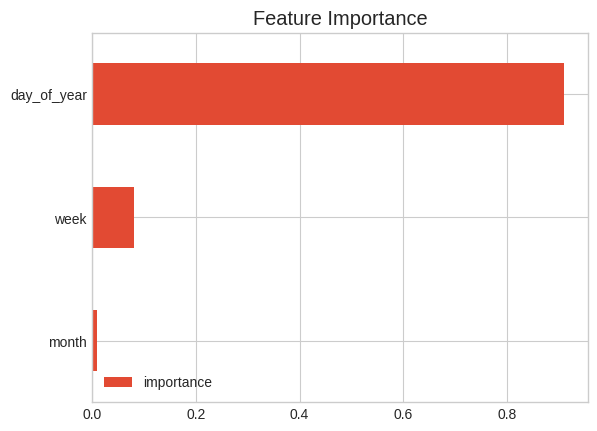

In [ ]:
importance = pd.DataFrame(data=regressor.feature_importances_, index=regressor.feature_names_in_,
            columns=['importance'])
importance = importance.sort_values('importance')
importance.plot.barh()
plt.title('Feature Importance')

The day of the year is the most important variable in predicting the onset of the discharge.

Text(0.5, 1.0, 'Model vs. 2023 Discharge Data')

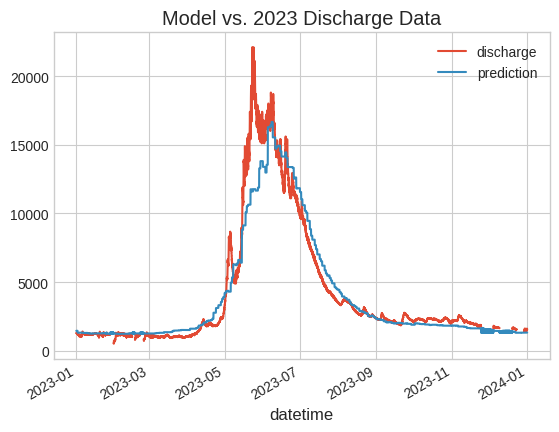

In [ ]:
predicted_2023 = test[test['year'] == 2023]
predicted_2023.plot(y=['discharge', 'prediction'])
plt.title('Model vs. 2023 Discharge Data')

This is a plot of the model prediction vs the actual 2023 data.  The timing of the onset looks really good.  However, the peak discharge is off a bit.

Text(0.5, 1.0, 'Model vs. 2024 Discharge Data')

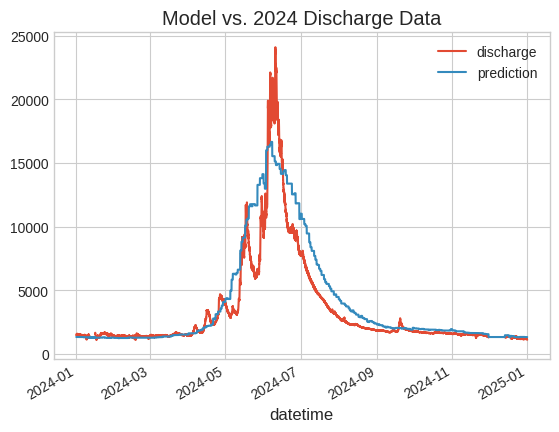

In [ ]:
predicted_2024 = test[test['year'] == 2024]
predicted_2024.plot(y=['discharge', 'prediction'])
plt.title('Model vs. 2024 Discharge Data')

Like the 2023 data, the model prediction for the 2024 data looks good for the onset of the discharge.  The peak discharge is off a bit again.  It seems that the model is underpredicting the peak discharge.  I suspect that this has something to do with the amount of snowpack in the mountains.  This is a potential future question to investigate.  Average daily temperatures could also be a useful variable to include in the model.  This should be the next step in improving the model.

In [ ]:
# Drop rows with NaN values in 'discharge' or 'prediction' columns
test_clean = test.dropna(subset=['discharge', 'prediction'])

# Calculate the mean squared error
mse = sk.metrics.mean_squared_error(test_clean['discharge'], test_clean['prediction'])
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 2206435.368551424
